# STEP02 BERT pre-training

This pipeline can be used to pre-train a BERT model on the next sentence prediction (NSP) and masked language modeling (MLM) tasks. Figure 1 illustrates what this pipeline does. First, if the user has not provided a vocabulary, the texts from the previous step are used to create a WordPiece vocabulary. Secondly, the sentence pairs are generated, labeled and tokenized if the sentences are consecutive or not. This is required for the NSP task. Finally the model is initialized and trained. If the user did not provide a bert config, then a default config is generated automatically. Note that the user can provide the vocabulary and the config by adding these to the model's directory. A collator is used to prepare the data for the MLM task.

![step01](images/step02.png)
**Figure 1.** Pipeline visualized

#### WARNING: Running these scripts create models, that take quite a bit of space.


In [1]:
# imports
from transformers import BertConfig, BertForPreTraining, BertTokenizerFast, TrainingArguments, IntervalStrategy
from pipelines.step02_BERT_pre_training.pre_train_BERT import pre_train_BERT
from pipelines.step02_BERT_pre_training.tokenizing.vocabulary_creator import create_vocabulary
from pipelines.step02_BERT_pre_training.pre_training.Callbacks import TsvLogWriterCallback, NotebookPreTrainingLogPlotCallback

# special tokens are directly used by the model
special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

# additional special tokens are added so the tokenizer wouldnt split these
additional_special_tokens = ["<INT>", "<FLOAT>", "<DATE>", "<XXX>", "<ADJ>", "<NAME>", "<ADV>", "<INJ>"]

# path to the text file(s) created in the previous step
training_files = ["data/corp_res_clean_r_events_par.tsv"]


# STEP02 Using the pipeline

*pipelines.step02_BERT_pre_training.pre_train_BERT.pre_train_BERT* - Initializes and pretrains BERT
* **model_path**     *(string)* path to the model directory, if the directory does not exist, then it is created
* **input_files**    *(string or [string])* path(s) to the input .tsv files
* **training_args**  *(TrainingArguments, default=None)*, Arguments used in training. If None, the default training
     args will be used (except do_train will be True and output_dir will be the model path). (See: [TrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments))

* **vocab_size** *(int)* The number of tokens to add into the vocabulary or is in the provided vocabulary (including the    special tokens)
* **bert_config**    *(BertConfig object, default=None)* bert config (See [BertConfig](https://huggingface.co/transformers/model_doc/bert.html#bertconfig))
* **mlm_probability** *(float, default=0.15)*, the probability that a token is masked.
* **nsp_probability** *(float, default=0.5)*, the probability that the next sentence is consecutive.
* **model_init** *(Callable[[], PreTrainedModel] = None)* A function that instantiates the model to be used. If provided, each call to train() will start from a new instance of the model as given by this function. (see [Trainer](https://huggingface.co/transformers/main_classes/trainer.html#id1))
* **callbacks**  *(Optional[List[TrainerCallback]] = None)* A list of callbacks to customize the training loop. (see [Callbacks](https://huggingface.co/transformers/main_classes/callback.html))
* **optimizers**  *Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (None, None)* A tuple containing the optimizer and the scheduler to use. Will default to an instance of AdamW on your model and a scheduler given by get_linear_schedule_with_warmup() controlled by args.
* ** **kwargs**:
    * **BertConfig** **kwargs: Only used if bert_config is None and there is no config file in model_path (See: [BertConfig](https://huggingface.co/transformers/model_doc/bert.html#bertconfig))
    * **BertTokenizerFast** **kwargs:  (See: [BertTokenizerFast](https://huggingface.co/transformers/model_doc/bert.html#berttokenizerfast))
    * **Tokenizer \_\_call__** **kwargs: (See: [BertTokenizer \_\_call__](https://huggingface.co/transformers/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.__call__))
   

In [2]:
model_path = "data/test_model"

training_args = TrainingArguments(
        output_dir=model_path,
        overwrite_output_dir=True,
        num_train_epochs=1,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_strategy=IntervalStrategy.STEPS,
        logging_dir=model_path + "/logs",
        logging_steps=100
    )

pre_train_BERT(model_path,
               training_files,
               training_args = training_args,
               vocab_size=3000, lowercase=False, max_length=128, truncation=True, padding=True,
               special_tokens=special_tokens, additional_special_tokens=additional_special_tokens)
# NOTE: truncation and padding here are Tokenizer __call__ keyword arguments.
# vocab_size is for the vocabulary and the config
# all special tokens are used by the vocabulary creation and BertTokenizerFast 

Using custom data configuration default-4e65cbec19320252
Reusing dataset csv (C:\Users\Meelis\.cache\huggingface\datasets\csv\default-4e65cbec19320252\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Loading cached processed dataset at C:\Users\Meelis\.cache\huggingface\datasets\csv\default-4e65cbec19320252\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff\cache-21ec7ffeb5f8f944.arrow


Step,Training Loss
100,7.990100
200,7.636100


# Creating a BertConfig

Sometimes it might be useful to provide your own [Bert configuration](https://huggingface.co/transformers/model_doc/bert.html#bertconfig). Here is how you can do it.

In [3]:
# just an example. See all the parameters at https://huggingface.co/transformers/model_doc/bert.html#bertconfig
bert_config = BertConfig(vocab_size=30000, hidden_size = 252) # note: this hidden size is not usually used.

model_path = "data/test_model1"
pre_train_BERT(model_path,
               training_files,
               training_args = training_args,
               bert_config=bert_config
              )

model = BertForPreTraining.from_pretrained(model_path)
print(model.config)

Using custom data configuration default-4e65cbec19320252
Reusing dataset csv (C:\Users\Meelis\.cache\huggingface\datasets\csv\default-4e65cbec19320252\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


  0%|          | 0/1 [00:00<?, ?ba/s]

Step,Training Loss
100,8.334100
200,7.967400


BertConfig {
  "_name_or_path": "data/test_model1",
  "architectures": [
    "BertForPreTrainingMod"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 252,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.7.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 3000
}



**Option 2**: The config parameters can also just be passed into the pipeline function. However a new config wont be created this way if there already is a config file in the model directory

In [4]:
model_path = "data/test_model2"
pre_train_BERT(model_path,
               training_files,
               training_args = training_args,
               hidden_size = 516
              )
model = BertForPreTraining.from_pretrained(model_path)
print(model.config)

Using custom data configuration default-4e65cbec19320252
Reusing dataset csv (C:\Users\Meelis\.cache\huggingface\datasets\csv\default-4e65cbec19320252\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


  0%|          | 0/1 [00:00<?, ?ba/s]

Step,Training Loss
100,7.990000
200,7.598300


BertConfig {
  "_name_or_path": "data/test_model2",
  "additional_special_tokens": [
    "<INT>",
    "<FLOAT>",
    "<DATE>",
    "<XXX>",
    "<ADJ>",
    "<NAME>",
    "<ADV>",
    "<INJ>"
  ],
  "architectures": [
    "BertForPreTrainingMod"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "lowercase": false,
  "max_length": 128,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "padding": true,
  "position_embedding_type": "absolute",
  "special_tokens": [
    "[PAD]",
    "[UNK]",
    "[CLS]",
    "[SEP]",
    "[MASK]"
  ],
  "transformers_version": "4.7.0",
  "truncation": true,
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 3000,
  "vocabulary_size": 3000
}



# Creating a vocabulary

This method should be used if you only want to create a WordPiece vocabulary. The *pre_train_BERT* pipeline already includes function.

*pipelines.step02_BERT_pre_training.tokenizing.vocabulary_creator.create_vocabulary* - creates a WordPiece vocabulary based on text files.
* **model_path**     *(string)* path to the model directory, if the directory does not exist, then it is created
* **files**    *(string or [string])* path(s) to the input .tsv files
* **size** *(int, default=8000)* The number of tokens to add into the vocabulary or is in the provided vocabulary (including the    special tokens)
* **special_tokens** *([string], default=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])* tokens that are used by the model
* **additional_special_tokens** *([string])* tokens that shouldnt be split
* **lowercase** *(boolean)* to lowercase the tokens (True) or not (False)

In [5]:
special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
additional_special_tokens = ["<INT>", "<FLOAT>", "<DATE>", "<XXX>", "<ADJ>", "<NAME>", "<ADV>", "<INJ>"]
training_files = ["data/corp_res_clean_r_events_par.tsv"]
model_path = "data/test_model"
create_vocabulary(model_path,
                  training_files,
                  size=3000,
                  special_tokens=special_tokens,
                  additional_special_tokens=additional_special_tokens,
                  lowercase=False)

# loading the tokenizer with the vocabulary that was just created
tokenizer = BertTokenizerFast.from_pretrained(model_path)
t = tokenizer("See on lause on mõteldud katsetamiseks.")
print(t)
print(tokenizer.decode(t['input_ids']))

{'input_ids': [2, 299, 197, 461, 204, 197, 75, 351, 2159, 1351, 1749, 194, 24, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[CLS] see on lause on moteldud katsetamiseks. [SEP]


# Callbacks

For a detailed description about callbacks [click here](https://huggingface.co/transformers/main_classes/callback.html).

There are 2 premade callbacks in this step of the pipeline:

 * **TsvLogWriterCallback** - writes the training logs to a .tsv file. It is done each log (after every training_arguments.logging_steps). The file will be located in *training_arguments.logging_dir* directory. If the directory is not found, then it does nothing.
 * **NotebookPreTrainingLogPlotCallback** - displays nsp and mlm loss plots on each log. Make sure that you use "%matplotlib notebook". When using it in the jupyter notebook. Otherwise it wont work.


Using custom data configuration default-4e65cbec19320252
Reusing dataset csv (C:\Users\Meelis\.cache\huggingface\datasets\csv\default-4e65cbec19320252\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Loading cached processed dataset at C:\Users\Meelis\.cache\huggingface\datasets\csv\default-4e65cbec19320252\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff\cache-21ec7ffeb5f8f944.arrow


<IPython.core.display.Javascript object>


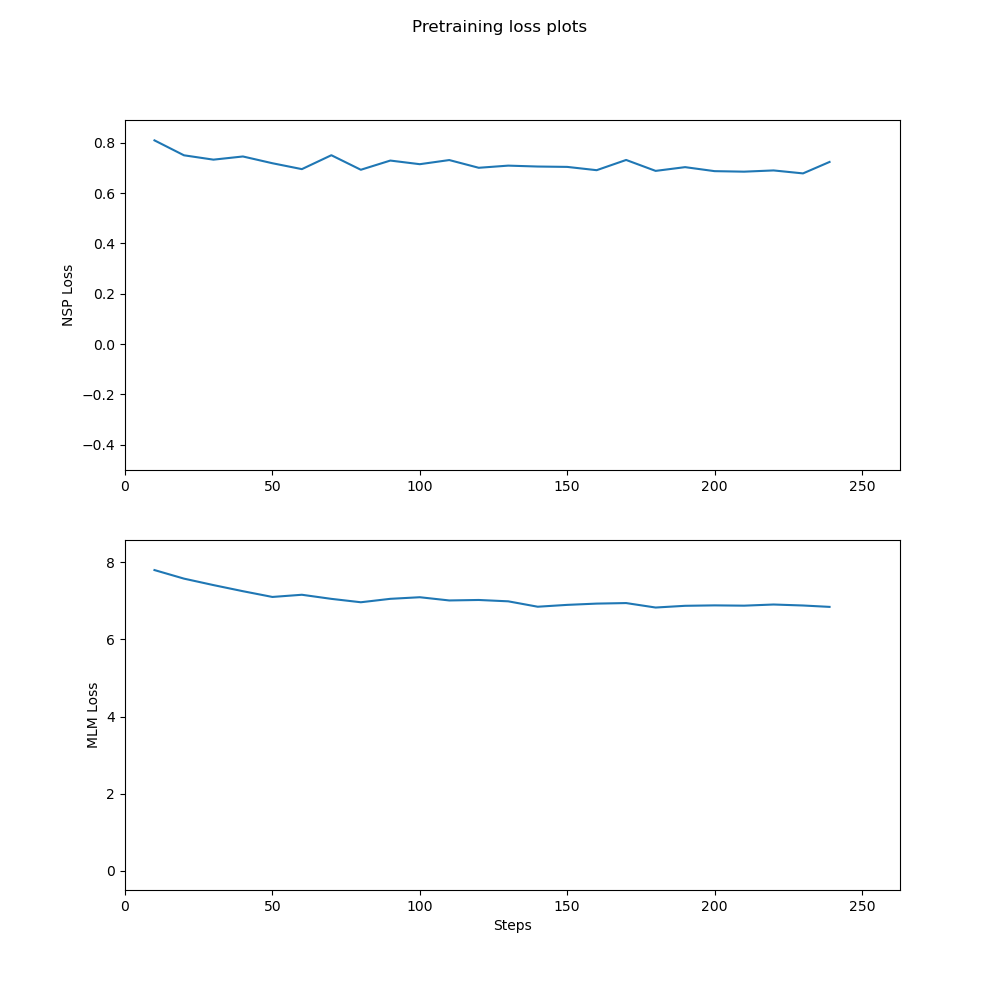

Step,Training Loss
10,8.609300
20,8.327900
30,8.143000
40,7.997000
50,7.821000
60,7.854400
70,7.803100
80,7.657500
90,7.782900
100,7.809900


In [6]:
# dont forget to add it
%matplotlib notebook 

model_path = "data/test_model"

training_args = TrainingArguments(
        output_dir=model_path,
        overwrite_output_dir=True,
        num_train_epochs=1,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_strategy=IntervalStrategy.STEPS,
        logging_dir=model_path + "/logs",
        logging_steps=10
    )

pre_train_BERT(model_path,
               training_files,
               training_args = training_args,
               callbacks=[NotebookPreTrainingLogPlotCallback], # Callbacks can be added like so
               vocab_size=3000, lowercase=False, max_length=128, truncation=True, padding=True,
               special_tokens=special_tokens, additional_special_tokens=additional_special_tokens)